C:\Users\Hatim\AppData\Local\Temp\ipykernel_25432\3135599947.py:14: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('enron_05_17_2015_with_labels_v2.csv\enron_05_17_2015_with_labels_v2.csv')
c:\Users\Hatim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
12935/12935 ━━━━━━━━━━━━━━━━━━━━ 254s 19ms/step - accuracy: 0.9963 - loss: 0.0257 - val_accuracy: 0.9969 - val_loss: 0.0201
Epoch 2/5
12935/12935 ━━━━━━━━━━━━━━━━━━━━ 260s 20ms/step - accuracy: 0.9966 - loss: 0.0202 - val_accuracy: 0.9969 - val_loss: 0.0199
Epoch 3/5
12935/12935 ━━━━━━━━━━━━━━━━━━━━ 289s 22ms/step - accuracy: 0.9967 - loss: 0.0176 - val_accuracy: 0.9969 - val_loss: 0.0192
Epoch 4/5
12935/12935 ━━━━━━━━━━━━━━━━━━━━ 242s 19ms/step - accuracy: 0.9967 - loss: 0.0157 - val_accuracy: 0.9969 - val_loss: 0.0201
Epoch 5/5
12935/12935 ━━━━━━━━━━━━━━━━━━━━ 240s 19ms/step - accuracy: 0.9969 - loss: 0.0139 - val_accuracy: 0.9969 - val_loss: 0.0187
3234/3234 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9970 - loss: 0.0187
Test Accuracy: 99.69%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Prediction: False


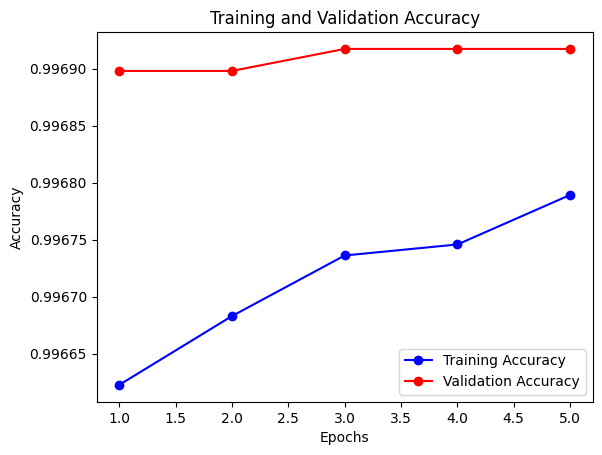

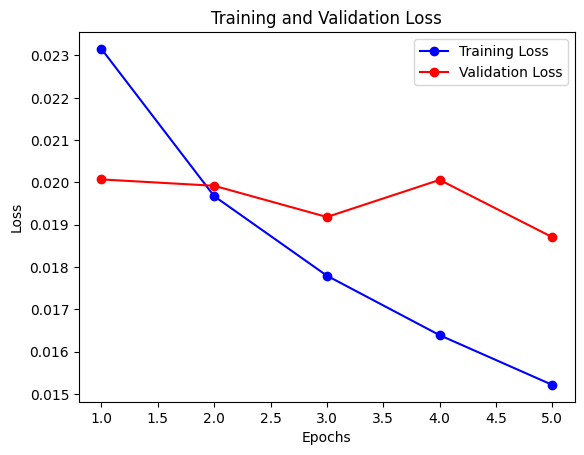

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('enron_05_17_2015_with_labels_v2.csv\enron_05_17_2015_with_labels_v2.csv')

# Preprocess the dataset
def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

df['Text'] = df['Subject'].fillna('') + ' ' + df['content'].fillna('')
df['Text'] = df['Text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['labeled'])

# Tokenization and Padding
MAX_WORDS = 10000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)
y = df['Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the model
model = Sequential()
model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Predict the spam/ham category of new messages
def predict_spam_ham(text):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN)
    prediction = model.predict(padded_sequence)
    return label_encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

# Example prediction
example_text = "Win a brand new car! Click here for details."
print(f"Prediction: {predict_spam_ham(example_text)}")

# Plotting training accuracy and loss
def plot_training_metrics(history, img_prefix='training'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure()
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{img_prefix}_accuracy.png')  # Save as image
    plt.show()

    # Loss plot
    plt.figure()
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{img_prefix}_loss.png')  # Save as image
    plt.show()

# Generate and save the plots
plot_training_metrics(history, img_prefix='enron_spam_detection')
